In [4]:
# mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#generate data
%cd /path/to/train/folder
!python /content/drive/MyDrive/achira_answer/gen_images.py --input /content/drive/MyDrive/achira_interview/input_images/ --out_dims 2600 --nout 150 --labels
!python /content/drive/MyDrive/achira_answer/gen_images.py --input /content/drive/MyDrive/achira_interview/input_images/ --out_dims 1280 --nout 150 --labels
!python /content/drive/MyDrive/achira_answer/gen_images.py --input /content/drive/MyDrive/achira_interview/input_images/ --out_dims 1024 --nout 150 --labels
!python /content/drive/MyDrive/achira_answer/gen_images.py --input /content/drive/MyDrive/achira_interview/input_images/ --out_dims 640 --nout 150 --labels

%cd /path/to/test/folder
!python /content/drive/MyDrive/achira_answer/gen_images.py --input /content/drive/MyDrive/achira_interview/input_images/ --out_dims 2600 --nout 25 --labels
!python /content/drive/MyDrive/achira_answer/gen_images.py --input /content/drive/MyDrive/achira_interview/input_images/ --out_dims 1280 --nout 25 --labels
!python /content/drive/MyDrive/achira_answer/gen_images.py --input /content/drive/MyDrive/achira_interview/input_images/ --out_dims 1024 --nout 25 --labels
!python /content/drive/MyDrive/achira_answer/gen_images.py --input /content/drive/MyDrive/achira_interview/input_images/ --out_dims 640 --nout 25 --labels

%cd /path/to/val/folder
!python /content/drive/MyDrive/achira_answer/gen_images.py --input /content/drive/MyDrive/achira_interview/input_images/ --out_dims 2600 --nout 10 --labels
!python /content/drive/MyDrive/achira_answer/gen_images.py --input /content/drive/MyDrive/achira_interview/input_images/ --out_dims 1280 --nout 10 --labels
!python /content/drive/MyDrive/achira_answer/gen_images.py --input /content/drive/MyDrive/achira_interview/input_images/ --out_dims 1024 --nout 10 --labels
!python /content/drive/MyDrive/achira_answer/gen_images.py --input /content/drive/MyDrive/achira_interview/input_images/ --out_dims 640 --nout 10 --labels

In [2]:
#clone YOLOv5 
%cd /path/to/main/folder
!git clone https://github.com/ultralytics/yolov5  # clone repo


#setup
%pip install -qr requirements.txt 

import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

/content/drive/.shortcut-targets-by-id/11g7nucj7hTE3YHwMNziSrwV2rZECLGDE/achira_answer
/content/drive/.shortcut-targets-by-id/11g7nucj7hTE3YHwMNziSrwV2rZECLGDE/achira_answer/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.7 MB/s eta 0:00:00
Setup complete. Using torch 1.13.1+cu116 (Tesla T4)


In [4]:
#training
%cd /path/to/yolov5/folder
!python train.py --epochs 6000 --data custom.yaml --cfg models/yolov5m.yaml --weights '' --cache

/content/drive/.shortcut-targets-by-id/11g7nucj7hTE3YHwMNziSrwV2rZECLGDE/achira_answer/yolov5
train: weights=, cfg=/content/drive/MyDrive/achira_answer/yolov5/models/yolov5m.yaml, data=/content/custom.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=6000, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 1 commit. Use 'git pull' or 'git clone https://github.com/ultralytics/yolov5' to update.
YOLOv5 🚀 v7.0-128-gb96f35c Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momen

In [ ]:
#prediction

import os
import sys
from pathlib import Path

import torch
import torch.backends.cudnn as cudnn

FILE = Path('').resolve() #path/to/yolov5/folder
ROOT = FILE#.parents[0]  # YOLOv5 root directory
print(ROOT)
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))  # add ROOT to PATH
ROOT = Path(os.path.relpath(ROOT, Path.cwd()))  # relative

from models.common import DetectMultiBackend
from utils.dataloaders import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr, cv2,  xywh2xyxy,
                           increment_path, non_max_suppression, print_args, scale_boxes, strip_optimizer, xyxy2xywh)
from utils.plots import Annotator, colors, save_one_box
from utils.torch_utils import select_device, time_sync
from PIL import Image
from google.colab.patches import cv2_imshow

@torch.no_grad()
def predict(
        weights=ROOT / 'yolov5s.pt',  # model.pt path(s)
        source=ROOT / 'data/images',  # file/dir/URL/glob, 0 for webcam
        data='custom.yaml',  # dataset.yaml path
        imgsz=(640, 640),  # inference size (height, width)
        conf_thres=0.5,  # confidence threshold
        iou_thres=0.45,  # NMS IOU threshold
        max_det=1000,  # maximum detections per image
        view_img=False,  # show results
        save_img=False, #save result
        ):
    source = str(source)
    is_file = Path(source).suffix[1:] in (IMG_FORMATS + VID_FORMATS)
    gain=1.02
    pad=10

    # Load model
    device = 0 
    device = select_device(device)
    model = DetectMultiBackend(weights, device=device, dnn=False, data=data, fp16=False)
    stride, names, pt = model.stride, model.names, model.pt
    imgsz = check_img_size(imgsz, s=stride)  # check image size

    dataset = LoadImages(source, img_size=imgsz, stride=stride, auto=pt)
    bs = 1  # batch_size

    # Run inference
    model.warmup(imgsz=(1 if pt else bs, 3, *imgsz))  # warmup
    dt, seen = [0.0, 0.0, 0.0], 0
    for path, im, im0s, vid_cap, s in dataset:
        t1 = time_sync()
        im = torch.from_numpy(im).to(device)
        im = im.half() if model.fp16 else im.float()  # uint8 to fp16/32
        im /= 255  # 0 - 255 to 0.0 - 1.0
        if len(im.shape) == 3:
            im = im[None]  # expand for batch dim
        t2 = time_sync()
        dt[0] += t2 - t1

        # Inference
        # visualize = increment_path(save_dir / Path(path).stem, mkdir=True) if visualize else False
        pred = model(im, augment=False, visualize=False)
        t3 = time_sync()
        dt[1] += t3 - t2

        # NMS
        classes = None
        agnostic_nms=False
        pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)
        dt[2] += time_sync() - t3

        #####################
        for i, det in enumerate(pred):  # per image
            seen += 1
            
            p, im0, frame = path, im0s.copy(), getattr(dataset, 'frame', 0)
            
            p = Path(p)  # to Path
            s += '%gx%g ' % im.shape[2:]  # print string
            gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
            imc = im0
            annotator = Annotator(im0, line_width=2, example=str(names))
            if len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_boxes(im.shape[2:], det[:, :4], im0.shape).round()

                # Print results
                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # detections per class
                    s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string]
                
                print(s)
                
                
                # Write results
                n = 0
                for *xyxy, conf, cls in reversed(det):                  
                  c = int(cls)  # integer class

                  label = (f'{names[c]} {conf:.2f}')
                  annotator.box_label(xyxy, label, color=colors(c, True))
        if save_img:
            save_path = str(p.name)
            cv2.imwrite(save_path, im0)
        if view_img:
            cv2_imshow(im0)

YOLOv5 🚀 v7.0-128-gb96f35c Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5m summary: 212 layers, 20865057 parameters, 0 gradients


image 1/1 /content/drive/.shortcut-targets-by-id/11g7nucj7hTE3YHwMNziSrwV2rZECLGDE/achira_answer/yolov5/imgs/000000_1024.jpg: 640x640 2 gears, 5 hexagons, 6 discs, 1 square, 


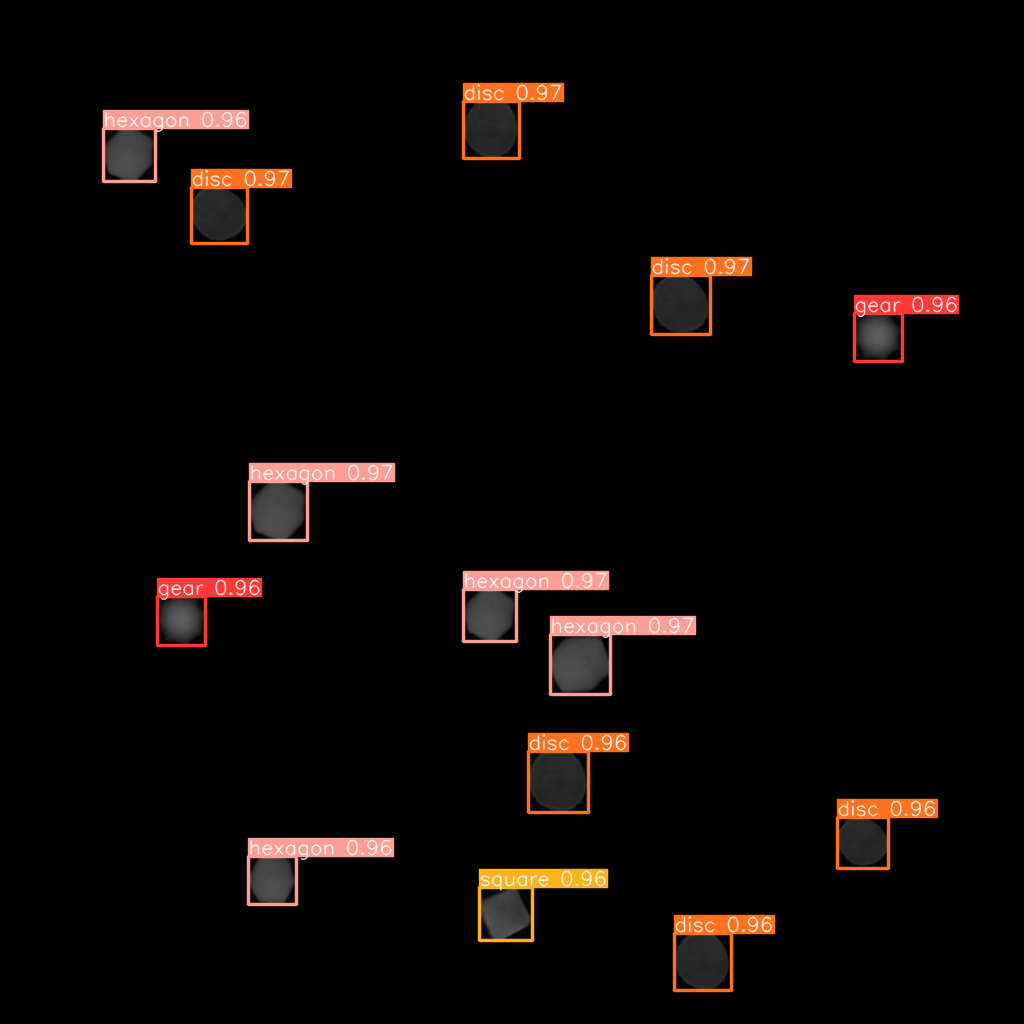

In [6]:
# to get results
predict(weights='best.pt', source='predict.jpg', view_img=True)

In [2]:
%cd path/to/yolov5/folder
!python val.py --weights 'best.pt' --data 'custom.yaml' --task 'test' 

/content/drive/.shortcut-targets-by-id/11g7nucj7hTE3YHwMNziSrwV2rZECLGDE/achira_answer/yolov5
val: data=/content/custom.yaml, weights=['/content/drive/MyDrive/achira_answer/yolov5/runs/train/exp4/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-128-gb96f35c Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5m summary: 212 layers, 20865057 parameters, 0 gradients
test: Scanning /content/drive/.shortcut-targets-by-id/11g7nucj7hTE3YHwMNziSrwV2rZECLGDE/achira_answer/labels/test.cache... 100 images, 0 backgrounds, 0 corrupt: 100% 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 4/4 [00:13<00:00,  3.44s/it]
               